In [1]:
import logging
from math import floor

from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Convolution2D
from tensorflow.python.keras.layers import Dropout, Flatten, Dense
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

try:
    from pathlib import Path
except ImportError:
    from pathlib2 import Path

import pandas as pd
import os
import numpy as np

logger = logging.getLogger(__name__)

/home/s/work/car/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/s/work/car/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/s/work/car/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/s/work/car/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:

IMAGE_INPUT_WIDTH=160
IMAGE_INPUT_HEIGHT=120
# This discards number of pixels from the top after scaling
TOP_MARGIN_IN_PIXELS=8

col_img = 'img'
col_steering = 'steering'
col_throttle = 'throttle'
col_steering_scaled = 'steering_scaled'
col_throttle_scaled = 'throttle_scaled'

base_dir = Path("./data/")
def read_csv(path):
    df = pd.read_csv(path, header=None, names=[col_img, col_steering, col_throttle])
    return df

In [3]:
paths_csv = sorted(base_dir.glob("*.csv"))
print('Found {} csvs:\n{}'.format(len(paths_csv), '\n'.join(str(p) for p in paths_csv)))

Found 15 csvs:
data/robocar_recording_20191008_2016-02-11-16-43-19_0_f.csv
data/robocar_recording_20191008_2016-02-11-16-46-19_1_f.csv
data/robocar_recording_20191008_2016-02-11-16-49-19_2_f.csv
data/robocar_recording__2016-02-11-16-35-11_0_f.csv
data/robocar_recording__2016-02-11-16-38-11_1.csv
data/robocar_recording__2016-02-11-16-52-47_0_f.csv
data/robocar_recording__2016-02-11-16-55-47_1.csv
data/robocar_recording__2016-02-11-16-58-47_2_f.csv
data/robocar_recording__2016-02-11-17-01-47_3_f.csv
data/robocar_recording__2016-02-11-17-04-47_4.csv
data/robocar_recording__2016-02-11-17-07-47_5.csv
data/robocar_recording__2016-02-11-17-10-47_6.csv
data/robocar_recording__2016-02-11-17-13-47_7.csv
data/robocar_recording__2016-02-11-17-16-47_8.csv
data/robocar_recording__2016-02-11-17-19-47_9.csv


# Read files and concatenate them

In [4]:
csvs = [read_csv(str(path)) for path in paths_csv]
df = pd.concat(csvs, axis=0, ignore_index=True)
# plt.plot(df.index, )

# defining scaling
radio pwm has a certain range and the data is recorded as is. Now it's time to preprocess it to make it generic

In [5]:
st_min, st_max = df[col_steering].quantile(q=[0.01, 0.99])
st_zero = np.mean([st_min, st_max])
st_min, st_max, st_zero

(1144.0, 1604.0, 1374.0)

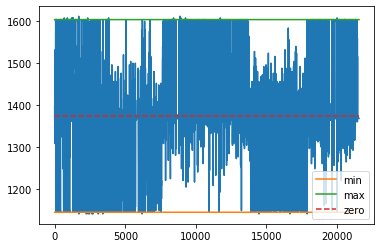

In [6]:
def plot_ranges(column, val_min, val_zero, val_max):
    f, ax = plt.subplots()
    ax.plot(column)
    ax.plot(column.index, df.index * 0 + val_min, label="min")
    ax.plot(column.index, df.index * 0 + val_max, label="max")
    ax.plot(column.index, df.index * 0 + val_zero, '--', label="zero")
    ax.legend()
    
plot_ranges(df[col_steering], st_min, st_zero, st_max)

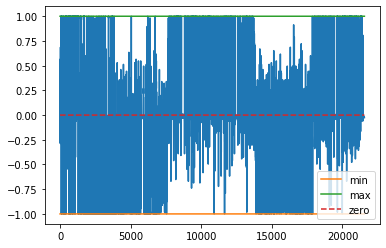

In [7]:
df[col_steering_scaled] = 0
df[col_steering_scaled] = np.clip(np.interp(df[col_steering], (st_min, st_zero, st_max), (-1, 0, +1)), -1, 1)
plot_ranges(df[col_steering_scaled], -1, 0, 1)


In [8]:
th_min, th_max = df[col_throttle].quantile(q=[0.0001, 0.999])
th_zero = 1515 # check it with your data
th_min, th_max, th_zero

(972.0, 2012.0, 1515)

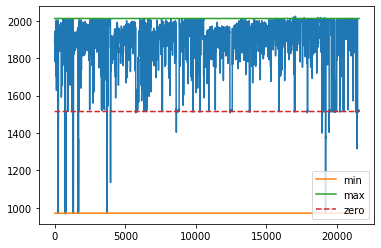

In [9]:
plot_ranges(df[col_throttle], th_min, th_zero, th_max, )

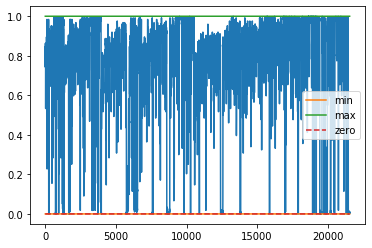

In [10]:
df[col_throttle_scaled] = np.clip(np.interp(df[col_throttle], (th_zero, th_max), (0, +1)), 0, 1)
plot_ranges(df[col_throttle_scaled], 0, 0, 1, )

## Select where actually driving

In [11]:
throttle_threshold = 0.3
df_filtered = df[df[col_throttle_scaled] > throttle_threshold]

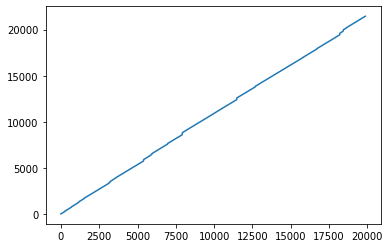

In [12]:
plt.plot(df_filtered.index)

In [13]:
datagen=ImageDataGenerator(validation_split=0.3, rescale=1./255)
# shuffle to avoid issue: https://github.com/keras-team/keras-preprocessing/issues/205
df_shuffled = df_filtered.sample(frac=1) 
def create_generator(df, subset):
    return datagen.flow_from_dataframe(dataframe=df, directory=str(base_dir),
        x_col=col_img,
        y_col=[col_steering_scaled, col_throttle_scaled],
        class_mode="multi_output",
        target_size=(IMAGE_INPUT_HEIGHT, IMAGE_INPUT_WIDTH),
        batch_size=32,
        shuffle=True,
        subset=subset
    )
train_generator=create_generator(df_shuffled, subset="training")
val_generator=create_generator(df_shuffled, subset="validation")


Found 13909 validated image filenames.
Found 5960 validated image filenames.


In [36]:
def visualize(imgs, y=None, pred=None):
    def format_(arr, idx):
        if arr is None:
            return "-"
        return ' '.join(['{:.3f}'.format(a.ravel()[idx]) for a in arr])
        
    _, axes = plt.subplots(8, 4, squeeze=False, figsize=(15,20), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0})
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i])
        
        text = "y {} \npred {}".format(format_(y, i), format_(pred, i))
        ax.text(20, 20, text, color='cyan')

In [37]:
np.set_printoptions(precision=3)

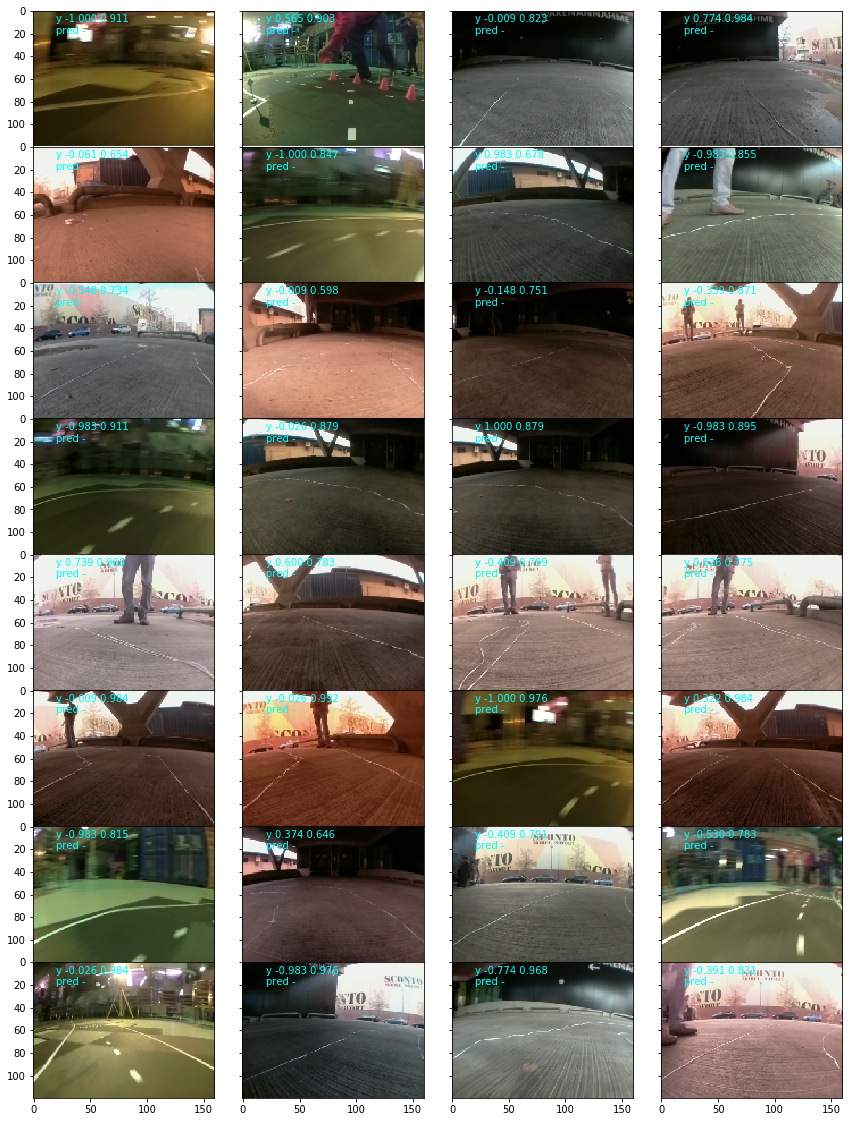

In [38]:
dbg_imgs, dbg_y = train_generator.next()
visualize(dbg_imgs, dbg_y)

In [29]:
dbg_y

[array([ 0.948, -0.53 , -0.27 , -0.165,  0.913, -0.478,  0.426, -0.026,
        -0.026,  0.896, -0.878,  0.374, -0.148, -0.983, -0.983, -0.409,
        -0.461,  0.6  ,  0.287,  0.983,  0.948, -0.722,  0.148,  0.27 ,
        -0.009,  0.739, -0.322,  0.026,  0.478,  0.6  , -0.009, -0.983]),
 array([0.96 , 0.968, 0.461, 0.807, 0.992, 0.799, 0.807, 0.847, 0.984,
        0.839, 0.815, 0.944, 0.694, 0.911, 0.911, 0.903, 0.96 , 0.694,
        0.879, 0.984, 0.928, 0.726, 0.767, 0.911, 0.887, 0.742, 0.911,
        0.807, 0.887, 0.863, 0.984, 0.887])]

In [18]:
def default_linear():
    img_in = Input(shape=(120, 160, 3), name='img_in')
    x = img_in

    # Convolution2D class name is an alias for Conv2D
    x = Convolution2D(filters=24, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=32, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(x)

    x = Flatten(name='flattened')(x)
    x = Dense(units=100, activation='linear')(x)
    x = Dropout(rate=.1)(x)
    x = Dense(units=50, activation='linear')(x)
    x = Dropout(rate=.1)(x)
    # categorical output of the angle
    angle_out = Dense(units=1, activation='linear', name='angle_out')(x)

    # continous output of throttle
    throttle_out = Dense(units=1, activation='linear', name='throttle_out')(x)

    model = Model(inputs=[img_in], outputs=[
        angle_out, 
        throttle_out
    ])

    model.compile(optimizer='adam',
                  loss={
                      'angle_out': 'mean_squared_error',
                      'throttle_out': 'mean_squared_error'
                  },
                  loss_weights={
                      'angle_out': 0.95, 
                      'throttle_out': .05
                  }
                 )

    return model

In [19]:
model = default_linear()

W1020 16:40:59.072438 139994875696960 deprecation.py:506] From /home/s/work/car/venv/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
use_early_stop = True
epochs = 10
saved_model_path = "./models/linear_first_try.model"
verbose = True
min_delta=.0005
patience=5

In [21]:
len(train_generator), train_generator.n, train_generator.batch_size, 40*32

(435, 13909, 32, 1280)

In [22]:
save_best = ModelCheckpoint(saved_model_path,
                            monitor='val_loss',
                            verbose=verbose,
                            save_best_only=True,
                            mode='min')

# stop training if the validation error stops improving.
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=min_delta,
                           patience=patience,
                           verbose=verbose,
                           mode='auto')

callbacks_list = [save_best]

if use_early_stop:
    callbacks_list.append(early_stop)

hist = model.fit_generator(
    train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    callbacks=callbacks_list)

Epoch 1/10
434/435 [============================>.] - ETA: 0s - loss: 0.2199 - angle_out_loss: 0.2286 - throttle_out_loss: 0.0551
Epoch 00001: val_loss improved from inf to 0.15071, saving model to ./models/linear_first_try.model
435/435 [==============================] - 67s 154ms/step - loss: 0.2197 - angle_out_loss: 0.2284 - throttle_out_loss: 0.0550 - val_loss: 0.1507 - val_angle_out_loss: 0.1576 - val_throttle_out_loss: 0.0196
Epoch 2/10
434/435 [============================>.] - ETA: 0s - loss: 0.1392 - angle_out_loss: 0.1454 - throttle_out_loss: 0.0216
Epoch 00002: val_loss improved from 0.15071 to 0.12115, saving model to ./models/linear_first_try.model
435/435 [==============================] - 67s 153ms/step - loss: 0.1392 - angle_out_loss: 0.1453 - throttle_out_loss: 0.0216 - val_loss: 0.1211 - val_angle_out_loss: 0.1268 - val_throttle_out_loss: 0.0138
Epoch 3/10
434/435 [============================>.] - ETA: 0s - loss: 0.1129 - angle_out_loss: 0.1178 - throttle_out_loss: 0

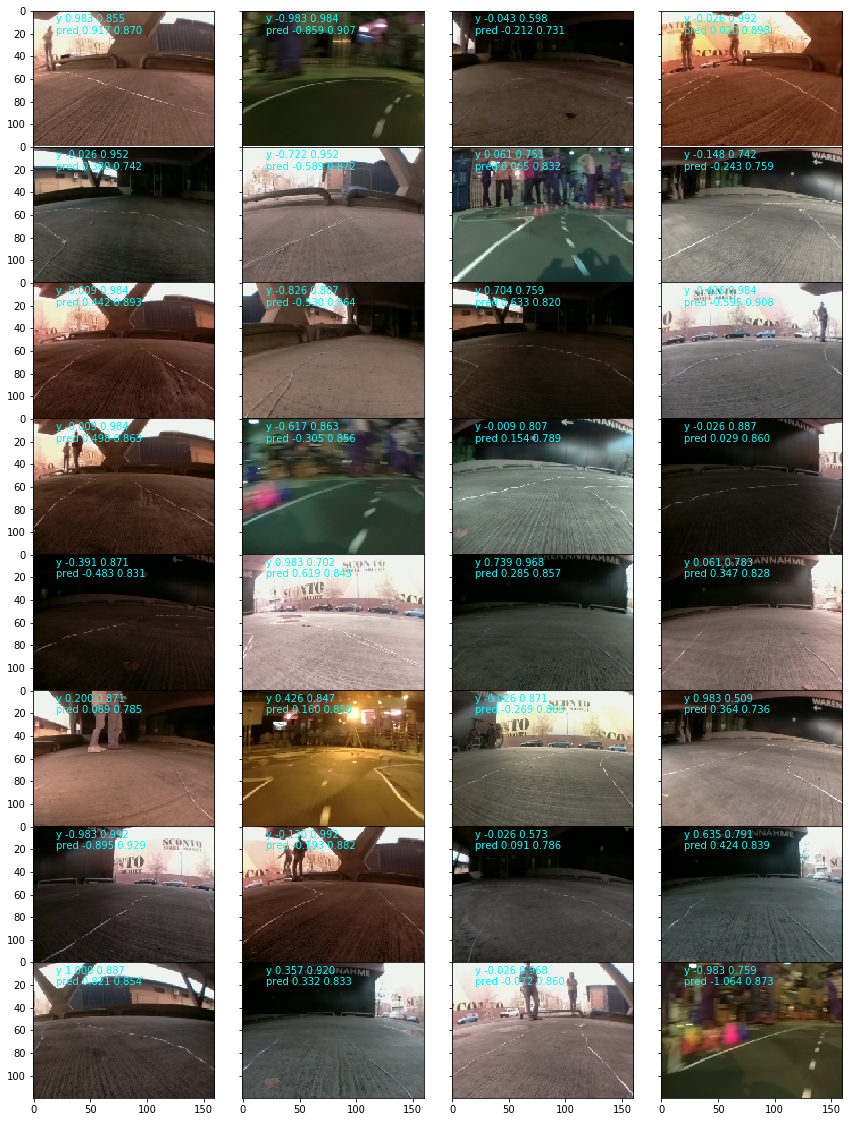

In [39]:
vis_imgs, vis_y = val_generator.next()
vis_pred = model.predict(vis_imgs)
visualize(vis_imgs, vis_y, vis_pred)

In [31]:
vis_y

[array([-0.026, -0.026, -0.948, -1.   , -0.026, -0.304, -0.67 ,  1.   ,
         0.843,  0.304, -0.235,  0.27 , -0.983, -0.983, -0.826, -0.026,
        -0.026, -0.009, -0.983, -0.026, -0.026, -0.026,  0.983, -0.548,
        -0.2  , -0.53 , -0.165,  0.983, -0.009,  0.2  , -0.009, -0.478]),
 array([0.775, 0.903, 0.831, 0.984, 0.879, 0.823, 0.799, 0.799, 0.831,
        0.887, 0.976, 0.984, 0.92 , 0.984, 0.783, 0.807, 0.686, 0.952,
        0.984, 0.984, 0.855, 0.622, 0.928, 0.71 , 0.807, 0.767, 0.823,
        0.984, 0.742, 0.823, 0.984, 0.895])]

In [32]:
vis_pred

[array([[-0.06 ],
        [-0.182],
        [-0.976],
        [-0.923],
        [-0.562],
        [-0.402],
        [-0.646],
        [ 0.877],
        [ 0.394],
        [-0.065],
        [-0.784],
        [ 0.477],
        [-1.396],
        [-1.03 ],
        [-0.99 ],
        [-0.21 ],
        [ 0.558],
        [ 0.233],
        [-1.494],
        [ 0.259],
        [ 0.234],
        [ 0.086],
        [ 0.647],
        [-0.401],
        [-0.159],
        [-0.606],
        [-0.147],
        [ 0.496],
        [-0.142],
        [-0.047],
        [-0.257],
        [-0.551]], dtype=float32), array([[0.851],
        [0.848],
        [0.865],
        [0.839],
        [0.881],
        [0.881],
        [0.832],
        [0.88 ],
        [0.849],
        [0.812],
        [0.871],
        [0.793],
        [0.927],
        [0.867],
        [0.861],
        [0.791],
        [0.82 ],
        [0.848],
        [0.87 ],
        [0.862],
        [0.819],
        [0.829],
        [0.892],
        [0.836],
